# Offline diagnostics for single output networks following Rasp et al. (2018) architecture

# Shapley Difference

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printe
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

In [3]:
module_path = os.path.abspath(os.path.join('..'))
# Relative imports
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from utils.setup import SetupDiagnostics
from neural_networks.load_models import load_models, get_save_plot_folder, load_single_model
from utils.pcmci_aggregation import get_matrix_idx, get_matrix_insets_idx, get_matrix_2d_idx
from neural_networks.model_diagnostics import ModelDiagnostics
from utils.variable import Variable_Lev_Metadata
from utils.constants import SPCAM_Vars
from utils.plotting import  plot_matrix_insets

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [5]:
from pathlib import Path
import pickle
import datetime
import time
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [8]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [9]:
font_size = 13


In [10]:
plt.rcParams["font.size"] = font_size
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Computer Modern"] + plt.rcParams["font.serif"]
plt.rcParams["mathtext.default"] = "regular"


## Load Shapley dictionaries

In [11]:
def get_setup(cfg_file):
    argv  = ["-c", cfg_file]
    return SetupDiagnostics(argv)

In [12]:
def parse_txt_to_dict(txt_file):
    line_dict = dict()
    with open(txt_file, 'r') as f:
        for line in f:
            value, key = line.split(":")
            line_dict[key.lstrip().rstrip("\n")] = value.lstrip().rstrip()
    return line_dict

In [13]:
def load_shap_dict(bdir):
    if "prediction_thresholds" in Path(bdir).name:
        shap_dir = Path(bdir, "plots_offline_evaluation", f"shap{val_train}", "range-all_samples-1000_all")
    else: 
        shap_dir = Path(bdir, "plots_offline_evaluation", "shap", "range-all_samples-1000_all")
    outputs_map = Path(bdir, "outputs_map.txt")
    
    outputs_varname2save = parse_txt_to_dict(outputs_map)
    outputs_save2varname = {value: key for key, value in outputs_varname2save.items()}
    
    shap_dict_per_var = {}
    for file in glob.glob(str(shap_dir) + "/*.p"):
        with open(file, "rb") as f:
            d = pickle.load(f)
        var_save_key = re.findall(r"[0-9]_[0-9]+",Path(file).name)[0]
        shap_dict_per_var[Variable_Lev_Metadata.parse_var_name(outputs_save2varname[var_save_key])] = d
    return shap_dict_per_var


## Calculate SHAP matrix

In [17]:
def generate_output_vars(setup):
    output_list = list()
    # Use setup.output_order here instead of setup.spcam_outputs to get the right order of variables
    for spcam_var in setup.spcam_outputs:
        if spcam_var.dimensions == 3:
            for level, _ in setup.children_idx_levs:
                # There's enough info to build a Variable_Lev_Metadata list
                # However, it could be better to do a bigger reorganization
                var_name = f"{spcam_var.name}-{round(level, 2)}"
                # For CausalSingleNN, there are no networks for variables phq-3.64 and phq-7.59
                if setup.nn_type == "CausalSingleNN" and (var_name == "phq-3.64" or var_name == "phq-7.59"):
                    continue
                output_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
        elif spcam_var.dimensions == 2:
            var_name = spcam_var.name
            output_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
    return output_list

In [18]:
def generate_input_vars(setup):
    inputs_list = list()
    for spcam_var in setup.spcam_inputs:
        if spcam_var.dimensions == 3:
            for level, _ in setup.parents_idx_levs:
                # There's enough info to build a Variable_Lev_Metadata list
                # However, it could be better to do a bigger reorganization
                var_name = f"{spcam_var.name}-{round(level, 2)}"
                inputs_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
        elif spcam_var.dimensions == 2:
            var_name = spcam_var.name
            inputs_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
    return sorted([p for p in inputs_list], key=lambda x: setup.input_order_list.index(x),)
    

In [19]:
def calculate_shap_matrix(setup, shap_dict_per_var, metric):
    output_vars = {i: var for i, var in enumerate(generate_output_vars(single_setup))}
    input_vars = generate_input_vars(setup)
    
    num_inputs = len(input_vars)
    
    input_inverse_idx = list(range(num_inputs-1, -1, -1))
    input_inverse_idx2var = {i: input_vars[num_inputs - 1 - i] for i in range(num_inputs)}
    
    
    metric_key = "shap_values_" + metric
    shap_matrix = np.ma.zeros([len(output_vars), len(input_vars)])
    
    for i, var in output_vars.items():
        if setup.nn_type == "CausalSingleNN" and (str(var) == "phq-3.64" or str(var) == "phq-7.59"):
            # No causal drivers were found for these variables
            continue
            
        var_inputs_idx = {input: idx for idx, input in enumerate(shap_dict_per_var[var]["inputs"])}
        for k in range(num_inputs):
            j = input_inverse_idx[k]
            # Check if this input is an input for the current variables
            try: 
                shap_matrix[i, k] = shap_dict_per_var[var][metric_key][var_inputs_idx[j]]
            except KeyError: 
                # This means the input was not part of the variables network inputs
                pass
            
    return shap_matrix, input_inverse_idx2var, output_vars


## Plot SHAP matrix

In [91]:
def plot_matrix( pc_alpha, matrix, in_vars, in_box_idx, in_ticks, in_ticks_labs, 
                out_vars, out_box_idx, out_ticks, out_ticks_labs, extend, 
                cbar_label, title=None, 
                **kwargs):
    vars_labs_dict = {
        'tbp': 'T (hPa)',
        'qbp': 'q (hPa)',
        'vbp': 'V (hPa)',
        'tphystnd': r'$\Delta$T$\mathregular{_{phy}}$ (hPa)',
        'phq': '$\Delta$q$\mathregular{_{phy}}$ (hPa)',
        # 'tphystnd':'dT/dt (hPa)',
        # 'phq':'dq/dt (hPa)',
    }

    # mpl.rcParams['font.size']      = 12
    # mpl.rcParams['axes.labelsize'] = 'large'

    fig, axes = plt.subplots(1, 1, figsize=(12, 5))
    
    I = axes.imshow(matrix, **kwargs)

    axes.tick_params(bottom=True, left=True, length=4)
    axes.tick_params(axis='x', labelsize=font_size)
    axes.tick_params(axis='y', labelsize=font_size)
    
    axes.set_xticks(in_ticks);
    axes.set_xticklabels(in_ticks_labs)
    axes.set_yticks(out_ticks);
    axes.set_yticklabels(out_ticks_labs)
    
    axes.vlines(in_box_idx, ymin=-.5, ymax=len(matrix), color='k')
    axes.hlines(out_box_idx, xmin=-.5, xmax=len(matrix[0]), color='k')

    axes.set_xlim(xmax=len(matrix[0]) - .5)
    axes.set_ylim(ymin=len(matrix) - .5)

    trans = axes.get_xaxis_transform()
    xy_coor = [(-15., .68), (-15., .20)]
    for i, iVar in enumerate(out_vars):
        axes.annotate(vars_labs_dict[iVar], xy=xy_coor[i], xycoords=trans, rotation=90, fontsize=font_size)
    axes.annotate('out-2Ds', xy=(-20.1, .005), xycoords=trans, rotation=0, fontsize=font_size)
    
    xy_coor = [(12., -.15), (42., -.15), (72., -.15)]
    for i, iVar in enumerate(in_vars):
        axes.annotate(vars_labs_dict[iVar], xy=xy_coor[i], xycoords=trans, rotation=0, fontsize=font_size)
    axes.annotate('in-2Ds', xy=(.6, -.25), xycoords=trans, rotation=90, fontsize=font_size)

    #  (left, bottom, width, height)
    cax = fig.add_axes([axes.get_position().x1 +0.01 , axes.get_position().y0, 
                        0.01, axes.get_position().height])
    cbar = plt.colorbar(I, cax=cax, extend=extend) # Similar to fig.colorbar(im, cax = cax)
    cbar.set_label(cbar_label, fontsize=font_size)
    
    axes.set_title(title, fontsize=font_size)
    return fig, axes

In [80]:
def plot_matrix_shap(clima_case, nn_case, metric, input_dict_inv_remap_var,  dict_outputs_idxs, 
                     shap_matrix, diff=False, save=False, savenm=False, cmap=False, 
                     extend=False, interpolation='none', title=None, insets=False, **kwargs):
    # diff doesn't do anything
    
    # Miscellaneous for plotting
    in_vars, in_box_idx, in_ticks, in_ticks_labs = get_matrix_insets_idx(input_dict_inv_remap_var, inverted=True)
    out_vars, out_box_idx, out_ticks, out_ticks_labs = get_matrix_insets_idx(dict_outputs_idxs, insets=insets)


    # Plotting
    if diff is False and 'abs' in metric and 'sign' not in metric:
        # norm = colors.LogNorm(vmin=0., vmax=shap_matrix.max())
        # norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=shap_matrix.min(), vmax=shap_matrix.max(), base=10)
        # norm = colors.PowerNorm(gamma=0.2)
        norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=0., vmax=shap_matrix.max(), base=10)
        if not cmap: cmap='Reds'
        if not extend: extend='max'
    
    else:
        maximum = max(abs(shap_matrix.max()), abs(shap_matrix.min()))
        # vmax=maximum; vmin=-1*maximum
        vmax=0.1
        vmin=-0.1
        norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=vmin, vmax=vmax, base=10)
        # norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=-1., vmax=1., base=10)
        if not cmap: cmap='RdBu_r'
        if not extend: extend='both'
        
    cbar_label='SHAP Value Difference'
    
    if insets:
        out_vars_2d, out_vars_2d_ticks = get_matrix_2d_idx(dict_outputs_idxs)
        fig, ax = plot_matrix_insets(None, shap_matrix, 
                                     in_vars, in_box_idx, in_ticks, in_ticks_labs,
                                     out_vars, out_box_idx,out_ticks, out_ticks_labs,
                                     out_vars_2d, out_vars_2d_ticks, 
                                     extend, cbar_label, 
                                     dict_outputs_idxs=dict_outputs_idxs,
                                     mask=False,num_parents=False, 
                                     # vmin=vmin,
                                     # vmax=vmax,
                                     cmap=cmap,
                                     # norm=colors.CenteredNorm(),
                                     # norm=colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=-1., vmax=1., base=10) 
                                     norm=norm,
                                     interpolation=interpolation, )
    else:
        fig, ax = plot_matrix(None, shap_matrix,
                              in_vars, in_box_idx, in_ticks, in_ticks_labs,
                              out_vars, out_box_idx, out_ticks,  out_ticks_labs,
                              extend, cbar_label, 
                              # vmin=vmin,
                              # vmax=vmax,
                              cmap=cmap,
                              # norm=colors.CenteredNorm(),
                              # norm=colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=-1., vmax=1., base=10)
                              norm=norm,
                              title=title,
                              interpolation=interpolation,)

    if save:
        Path(save).mkdir(parents=True, exist_ok=True)
        f_name = f'SHAP_values_diff_{nn_case}_{clima_case}_{metric}' if not savenm else savenm
        fig.savefig(f"{save}/{f_name}.pdf", format="pdf", transparent=True, bbox_inches="tight")
        fig.savefig(f"{save}/{f_name}.png",dpi=600.,bbox_inches='tight')

        print(f"Saved Shapley matrix {save}/{f_name}")
    return fig, ax

## SHAP matrices

### Metric

In [46]:
metric = "abs_mean"
# PROJECT_ROOT = Path.cwd().parent.resolve()
PROJECT_ROOT = Path("/p/scratch/icon-a-ml/kuehbacher1")

### SingelNN SHAP matrix

In [47]:
# single_base_dir = os.path.join(PROJECT_ROOT, "output_castle", "eval_nando", "single_nn") 
# single_cfg = os.path.join(single_base_dir, "cfg_single_nn_diagnostics.yml")

single_base_dir = os.path.join(PROJECT_ROOT, "output_castle", "training_94_single_nn")
single_cfg = os.path.join(single_base_dir, "cfg_single_nn.yml")

single_setup = get_setup(single_cfg)

single_shap_dict_per_var = load_shap_dict(single_base_dir)

assert (len(single_shap_dict_per_var.keys()) == 65)

In [48]:
single_shap_matrix_abs_mean, single_input_inverse_idx2var, single_output_vars = \
    calculate_shap_matrix(single_setup, single_shap_dict_per_var, metric)

assert (single_shap_matrix_abs_mean.shape == (65, 94))

### CausalNN SHAP matrix

#### CausalNN 1 (standard)

In [49]:
causal_base_dir = os.path.join(PROJECT_ROOT, "output_castle", "eval_nando", "causal_single_nn", 
                              "models_arch-rasp_thrs-opt-mse6") 
# causal_base_dir = os.path.join(PROJECT_ROOT, "output_castle", "eval_nando", "causal_single_nn", 
#                               "models_arch-rasp_thrs-opt-mse6_extra_2") 
# causal_base_dir = os.path.join(PROJECT_ROOT, "output_castle", "eval_nando", "causal_single_nn", 
#                               "models_arch-rasp_thrs-opt-r2max") 

causal_cfg = os.path.join(causal_base_dir, "cfg_causal_single_nn_diagnostics.yml")
causal_setup = get_setup(causal_cfg)

causal_shap_dict_per_var = load_shap_dict(causal_base_dir)

assert (len(causal_shap_dict_per_var.keys()) == 63)

In [50]:
causal_shap_matrix_abs_mean, causal_input_inverse_idx2var, causal_output_vars = \
    calculate_shap_matrix(causal_setup, causal_shap_dict_per_var, metric)

assert (causal_shap_matrix_abs_mean.shape == (65, 94))

#### CausalNN 2

In [51]:
causal_base_dir_2 = os.path.join(PROJECT_ROOT, "output_castle", "eval_nando", "causal_single_nn", 
                              "models_arch-rasp_thrs-opt-mse6_extra_2") 

causal_cfg_2 = os.path.join(causal_base_dir_2, "cfg_causal_single_nn_diagnostics.yml")
causal_setup_2 = get_setup(causal_cfg_2)

causal_shap_dict_per_var_2 = load_shap_dict(causal_base_dir_2)

assert (len(causal_shap_dict_per_var_2.keys()) == 63)

In [52]:
causal_shap_matrix_abs_mean_2, causal_input_inverse_idx2var_2, causal_output_vars_2 = \
    calculate_shap_matrix(causal_setup_2, causal_shap_dict_per_var_2, metric)

assert (causal_shap_matrix_abs_mean_2.shape == (65, 94))

#### CausalNN 3

In [53]:
causal_base_dir_3 = os.path.join(PROJECT_ROOT, "output_castle", "eval_nando", "causal_single_nn", 
                                 "models_arch-rasp_thrs-opt-r2max") 

causal_cfg_3 = os.path.join(causal_base_dir_3, "cfg_causal_single_nn_diagnostics.yml")
causal_setup_3 = get_setup(causal_cfg_3)

causal_shap_dict_per_var_3 = load_shap_dict(causal_base_dir_3)

assert (len(causal_shap_dict_per_var_3.keys()) == 63)

In [54]:
causal_shap_matrix_abs_mean_3, causal_input_inverse_idx2var_3, causal_output_vars_3 = \
    calculate_shap_matrix(causal_setup_3, causal_shap_dict_per_var_3, metric)

assert (causal_shap_matrix_abs_mean_3.shape == (65, 94))

### PreMaskNet SHAP matrix

In [55]:
# training_77_pre_mask_net_spars1.0
# training_78_pre_mask_net_spars0.1
# training_79_pre_mask_net_spars0.01
# training_74_pre_mask_net_spars0.001
# training_80_pre_mask_net_spars1e-4
# training_81_pre_mask_net_spars1e-5

pre_mask_net_base_dir = os.path.join(PROJECT_ROOT, "output_castle", "training_74_pre_mask_net_spars0.001") 
pre_mask_net_cfg = os.path.join(pre_mask_net_base_dir, "cfg_pre_mask_net.yml")
pre_mask_net_setup = get_setup(pre_mask_net_cfg)

pre_mask_net_shap_dict_per_var = load_shap_dict(pre_mask_net_base_dir)

assert (len(pre_mask_net_shap_dict_per_var.keys()) == 65)


Set leaky relu alpha to 0.3



In [56]:
pre_mask_net_shap_matrix_abs_mean, pre_mask_net_input_inverse_idx2var, pre_mask_net_output_vars = \
    calculate_shap_matrix(pre_mask_net_setup, pre_mask_net_shap_dict_per_var, metric)

assert (pre_mask_net_shap_matrix_abs_mean.shape == (65, 94))

### MaskNet SHAP matrix

In [66]:
# training_88_mask_net_prediction_thresholds_spars1.0
# training_89_mask_net_prediction_thresholds_spars0.1
# training_90_mask_net_prediction_thresholds_spars0.01
# training_91_mask_net_prediction_thresholds_spars0.001
# training_92_mask_net_prediction_thresholds_spars1e-4
# training_93_mask_net_prediction_thresholds_spars1e-5

# "training_95_mask_net_prediction_thresholds_spars1.0"
# "training_96_mask_net_prediction_thresholds_spars0.1"
# "training_97_mask_net_prediction_thresholds_spars0.01"
# "training_98_mask_net_prediction_thresholds_spars0.001"
# "training_99_mask_net_prediction_thresholds_spars1e-4"
# "training_100_mask_net_prediction_thresholds_spars1e-5"

# mask_net_base_dir = os.path.join(PROJECT_ROOT, "output_castle", "training_75_mask_net_bespoke_thresholds")
mask_net_base_dir = os.path.join(PROJECT_ROOT, "output_castle", "training_91_mask_net_prediction_thresholds_spars0.001") 
val_train = "_train"

if "prediction_thresholds" in Path(mask_net_base_dir).name:   
    mask_net_cfg = os.path.join(mask_net_base_dir, f"cfg_mask_net_thresholds{val_train}.yml")
else: 
    mask_net_cfg = os.path.join(mask_net_base_dir, "cfg_mask_net.yml")

mask_net_setup = get_setup(mask_net_cfg)

mask_net_shap_dict_per_var = load_shap_dict(mask_net_base_dir)

assert (len(mask_net_shap_dict_per_var.keys()) == 65)


Set leaky relu alpha to 0.3



In [67]:
mask_net_shap_matrix_abs_mean, mask_net_input_inverse_idx2var, mask_net_output_vars = \
    calculate_shap_matrix(mask_net_setup, mask_net_shap_dict_per_var, metric)

assert (mask_net_shap_matrix_abs_mean.shape == (65, 94))

## Differences

### SingleNN - MaskNet

In [92]:
if "prediction_thresholds" in Path(mask_net_base_dir).name:
    mask_net_base_shap_dir = Path(mask_net_base_dir, "plots_offline_evaluation", f"shap{val_train}", "range-all_samples-1000_all")
else: 
    mask_net_base_shap_dir = Path(mask_net_base_dir, "plots_offline_evaluation", "shap", "range-all_samples-1000_all")
output_dir = os.path.join(mask_net_base_shap_dir, "single_diff")

print(output_dir)

/p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/shap_train/range-all_samples-1000_all/single_diff


In [93]:
title = "Standard NN - PCMasking NN"

In [94]:
shap_diff = single_shap_matrix_abs_mean - mask_net_shap_matrix_abs_mean

Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/shap_train/range-all_samples-1000_all/single_diff/SHAP_values_diff_singleNN-MaskNet_0K_diff


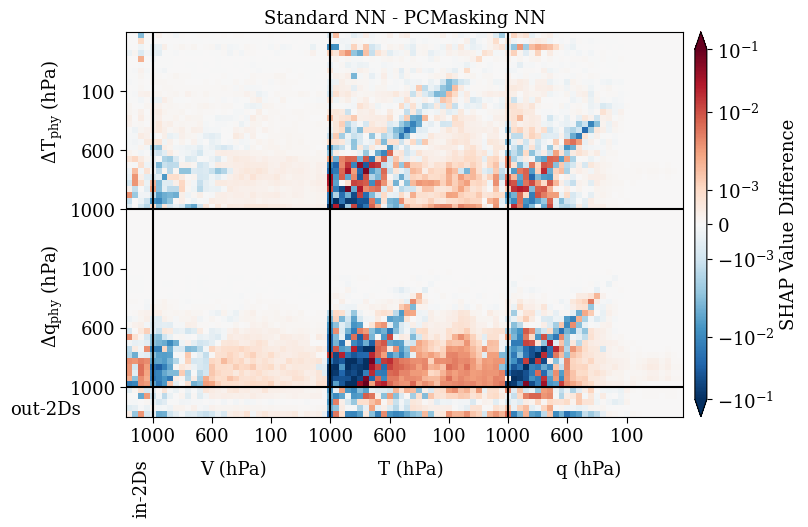

In [95]:
fig, ax = plot_matrix_shap("0K", "singleNN-MaskNet", "diff", mask_net_input_inverse_idx2var, 
                           mask_net_output_vars, shap_diff, title=title, 
                           save=output_dir)

### SingleNN - CausalSingleNN

In [175]:
# single_base_shap_dir = Path(single_base_dir, "plots_offline_evaluation", "shap", "range-all_samples-1000_all")
# output_dir = os.path.join(single_base_shap_dir, "causal_diff")
# print(output_dir)

causal_base_shap_dir = Path(causal_base_dir, "plots_offline_evaluation", "shap", "range-all_samples-1000_all")
output_dir = os.path.join(causal_base_shap_dir, "single_diff")
print(output_dir)

/p/scratch/icon-a-ml/kuehbacher1/output_castle/eval_nando/causal_single_nn/models_arch-rasp_thrs-opt-mse6/plots_offline_evaluation/shap/range-all_samples-1000_all/single_diff


In [176]:
shap_diff = single_shap_matrix_abs_mean - causal_shap_matrix_abs_mean

Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output_castle/eval_nando/causal_single_nn/models_arch-rasp_thrs-opt-mse6/plots_offline_evaluation/shap/range-all_samples-1000_all/single_diff/SHAP_values_singleNN-causalNN_0K_diff.png


FigureCanvasAgg is non-interactive, and thus cannot be shown


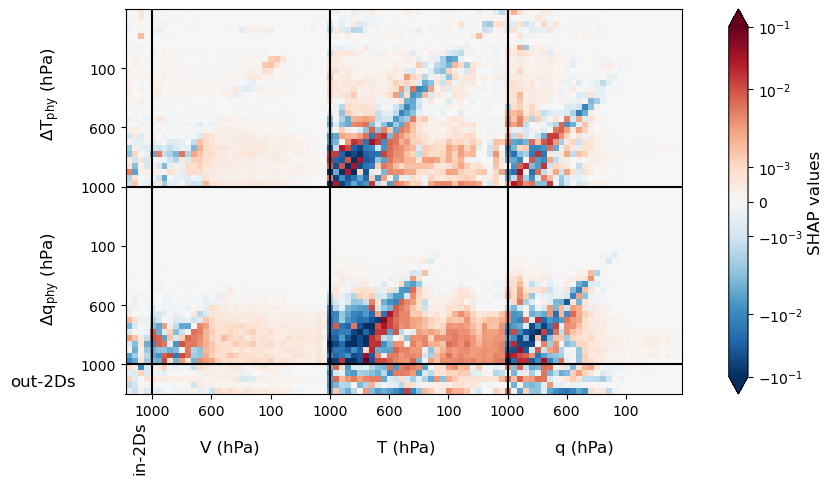

In [177]:
fig, ax = plot_matrix_shap("0K", "singleNN-causalNN", "diff", single_input_inverse_idx2var, single_output_vars, shap_diff, save=output_dir)
fig.show()

### PreMaskNet - MaskNet

In [96]:
if "prediction_thresholds" in Path(mask_net_base_dir).name:
    mask_net_base_shap_dir = Path(mask_net_base_dir, "plots_offline_evaluation", f"shap{val_train}", "range-all_samples-1000_all")
else: 
    mask_net_base_shap_dir = Path(mask_net_base_dir, "plots_offline_evaluation", "shap", "range-all_samples-1000_all")
output_dir = os.path.join(mask_net_base_shap_dir, "pre_mask_net_diff")
print(output_dir)

/p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/shap_train/range-all_samples-1000_all/pre_mask_net_diff


In [97]:
shap_diff = pre_mask_net_shap_matrix_abs_mean - mask_net_shap_matrix_abs_mean

Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/shap_train/range-all_samples-1000_all/pre_mask_net_diff/SHAP_values_diff_PreMaskNet-MaskNet_0K_diff


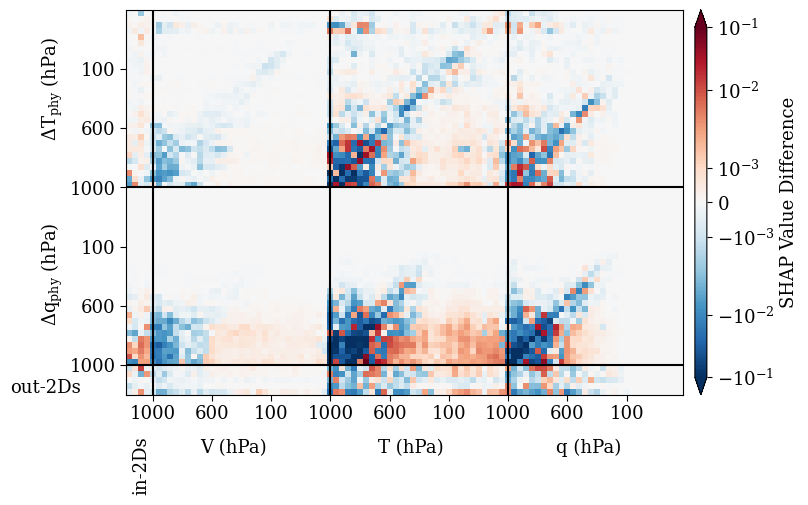

In [98]:
fig, ax = plot_matrix_shap("0K", "PreMaskNet-MaskNet", "diff", mask_net_input_inverse_idx2var, 
                           mask_net_output_vars, shap_diff, save=output_dir)


### SingleNN - PreMaskNet

In [181]:
pre_mask_net_base_shap_dir = Path(pre_mask_net_base_dir, "plots_offline_evaluation", "shap", "range-all_samples-1000_all")
output_dir = os.path.join(pre_mask_net_base_shap_dir, "single_diff")
print(output_dir)

/p/scratch/icon-a-ml/kuehbacher1/output_castle/training_81_pre_mask_net_spars1e-5/plots_offline_evaluation/shap/range-all_samples-1000_all/single_diff


In [182]:
shap_diff = pre_mask_net_shap_matrix_abs_mean - single_shap_matrix_abs_mean

Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_81_pre_mask_net_spars1e-5/plots_offline_evaluation/shap/range-all_samples-1000_all/single_diff/SHAP_values_PreMaskNet-singleNN_0K_diff.png


FigureCanvasAgg is non-interactive, and thus cannot be shown


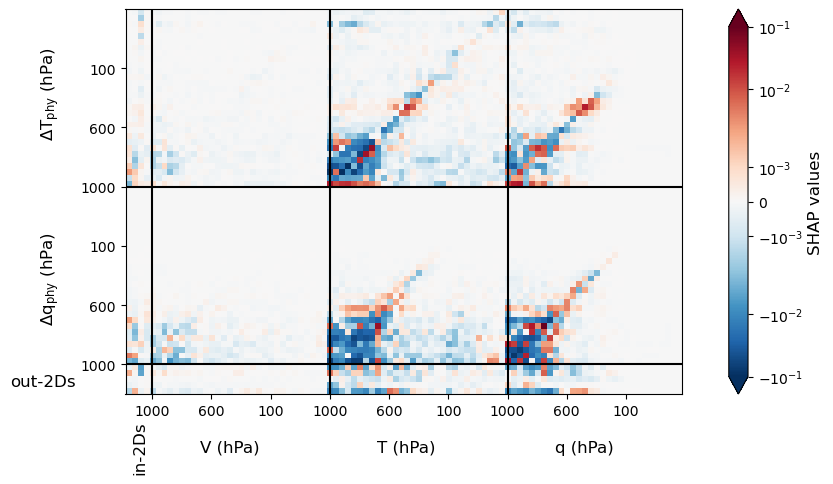

In [183]:
fig, ax = plot_matrix_shap("0K", "PreMaskNet-singleNN", "diff", pre_mask_net_input_inverse_idx2var, 
                           pre_mask_net_output_vars, shap_diff, save=output_dir)
fig.show()

### MaskNet - CausalSingleNN

In [99]:
if "prediction_thresholds" in Path(mask_net_base_dir).name:
    mask_net_base_shap_dir = Path(mask_net_base_dir, "plots_offline_evaluation", f"shap{val_train}", "range-all_samples-1000_all")
else: 
    mask_net_base_shap_dir = Path(mask_net_base_dir, "plots_offline_evaluation", "shap", "range-all_samples-1000_all")
output_dir = os.path.join(mask_net_base_shap_dir, "causal_diff")
print(output_dir)

# causal_base_shap_dir = Path(causal_base_dir, "plots_offline_evaluation", "shap", "range-all_samples-1000_all")
# output_dir = os.path.join(causal_base_shap_dir, "mask_net_diff")
# print(output_dir)

/p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/shap_train/range-all_samples-1000_all/causal_diff


In [100]:
shap_diff = mask_net_shap_matrix_abs_mean - causal_shap_matrix_abs_mean

Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/shap_train/range-all_samples-1000_all/causal_diff/SHAP_values_diff_MaskNet-causalNN_0K_diff


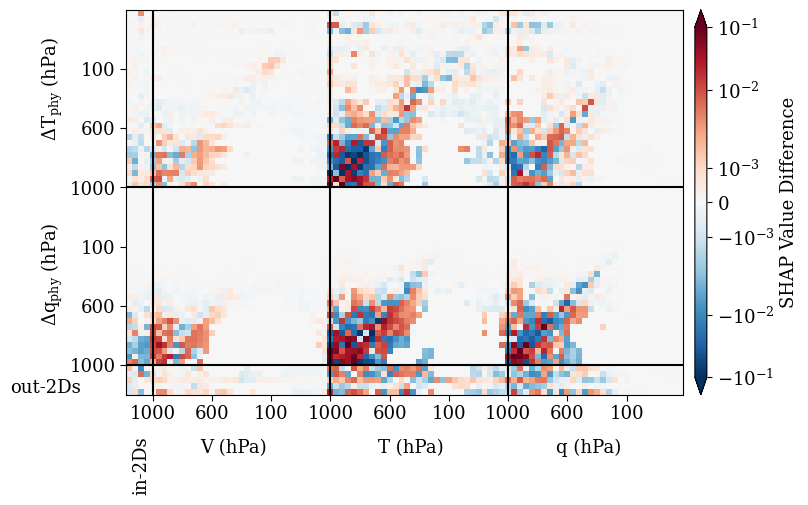

In [101]:
fig, ax = plot_matrix_shap("0K", "MaskNet-causalNN", "diff", mask_net_input_inverse_idx2var, 
                           mask_net_output_vars, shap_diff, save=output_dir)


### CausalNN differences

In [44]:
output_dir = os.path.join(PROJECT_ROOT, "output_castle", "eval_nando", "causal_single_nn") 
output_dir = os.path.join(output_dir, "shap_diffs", "range-all_samples-1000_all")
print(output_dir)

/p/scratch/icon-a-ml/kuehbacher1/output_castle/eval_nando/causal_single_nn/shap_diffs/range-all_samples-1000_all


In [46]:
shap_diff = causal_shap_matrix_abs_mean_2 - causal_shap_matrix_abs_mean

Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output_castle/eval_nando/causal_single_nn/shap_diffs/range-all_samples-1000_all/SHAP_values_Causal2-Causal1_0K_diff.png


FigureCanvasAgg is non-interactive, and thus cannot be shown


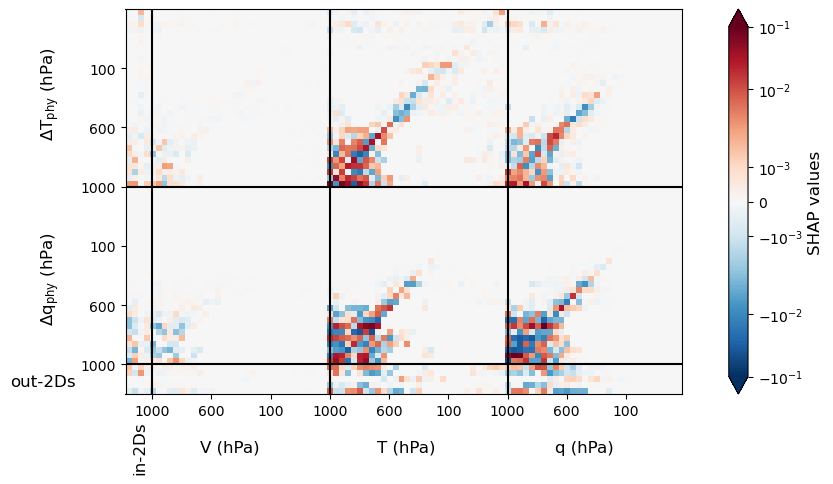

In [47]:
fig, ax = plot_matrix_shap("0K", "Causal2-Causal1", "diff", causal_input_inverse_idx2var, 
                           causal_output_vars, shap_diff, save=output_dir)
fig.show()

In [48]:
shap_diff = causal_shap_matrix_abs_mean_3 - causal_shap_matrix_abs_mean

Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output_castle/eval_nando/causal_single_nn/shap_diffs/range-all_samples-1000_all/SHAP_values_Causal3-Causal1_0K_diff.png


FigureCanvasAgg is non-interactive, and thus cannot be shown


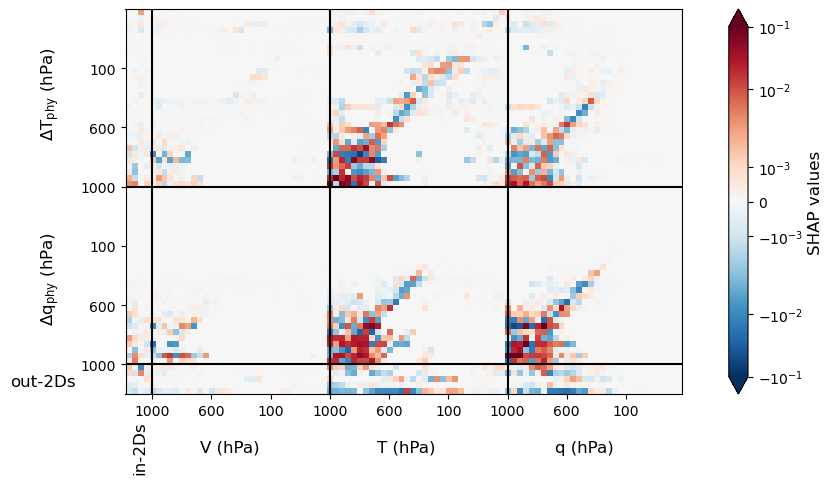

In [49]:
fig, ax = plot_matrix_shap("0K", "Causal3-Causal1", "diff", causal_input_inverse_idx2var, 
                           causal_output_vars, shap_diff, save=output_dir)
fig.show()

In [50]:
shap_diff = causal_shap_matrix_abs_mean_3 - causal_shap_matrix_abs_mean_2

Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output_castle/eval_nando/causal_single_nn/shap_diffs/range-all_samples-1000_all/SHAP_values_Causal3-Causal2_0K_diff.png


FigureCanvasAgg is non-interactive, and thus cannot be shown


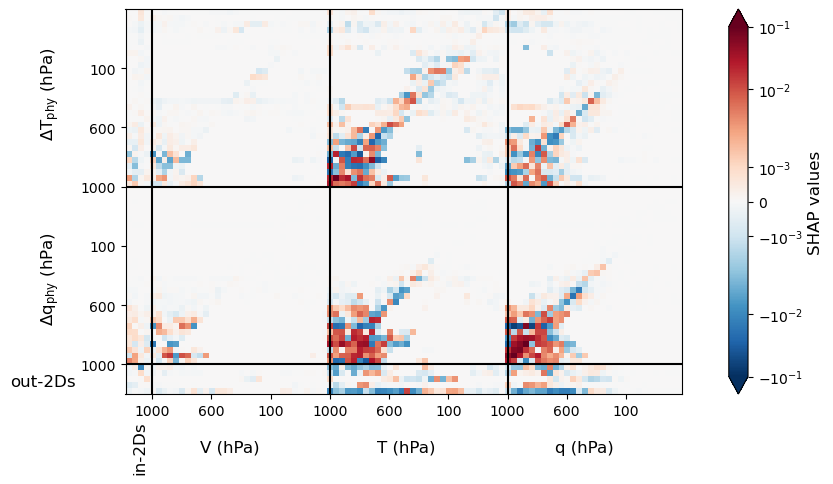

In [51]:
fig, ax = plot_matrix_shap("0K", "Causal3-Causal2", "diff", causal_input_inverse_idx2var, 
                           causal_output_vars, shap_diff, save=output_dir)
fig.show()